In [7]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import numpy as np

## Add functions necessary to implement model weights in a new image.
- Python scripts with functions are stored in tools folder.
- Append the folder where scripts are stored. 


In [2]:
import sys
sys.path.append('../tools')
#!pip install patchify If using in colab
from patchify import patchify, unpatchify
from unet_segmentation import unet_segment
from simple_unet_model import simple_unet_model

## Load model weights 
- Path weights specifies the folder where the model weights obtained after training is stored (stored as a .hdf5 file).

In [3]:
path_weights = '../model-weights/loss_iou_v1.0.hdf5'

## Using validation images to test model prediction on new images.

Dont forget that we need to add both original mask and original rgb to compare with other models.

In [33]:
path_rgb = '../images/validation_imgs/original_rgb/73_rgb.jpg'
path_mask= '../images/validation_imgs/original_mask/73_mask.jpg'

## Using unet_segment function from the script imported to create a new mask for the RGB image stored above and using specified weights.

In [23]:
predicted_mask = unet_segment(path_weights, path_rgb)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 320, 320, 16)         448       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 320, 320, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 320, 320, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

## Inspect prediction outpur 
Predicted binary mask has values of either 0 for background or 1 for plant tissue.

[0 1]


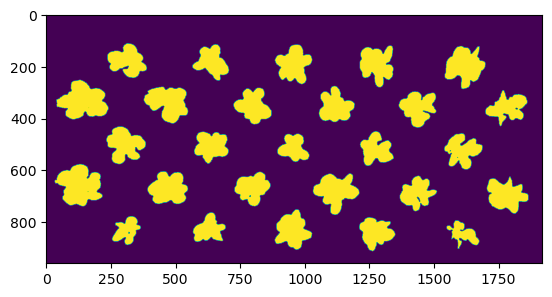

In [24]:
#predicted_mask --> Make sire it is in binary format. 
print(np.unique(predicted_mask))
plt.imshow(predicted_mask)

## Display original color image and binary mask together.

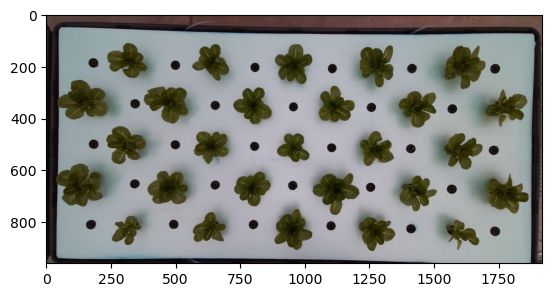

In [30]:
#from google.colab.patches import 
# Notice that cv2 reads it as BGR
img_bgr = cv2.imread(path_rgb, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

#window_name = "Image"
plt.imshow(img_rgb)  # Pay special attention to "_" (underscore)
#plt.imshow(mask_norm)

[0 1]


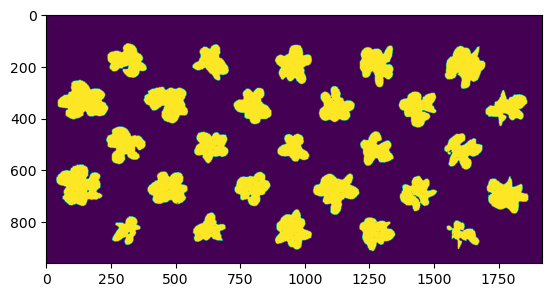

In [38]:
original_mask = cv2.imread(path_mask,0) # read as grayscale
original_mask = cv2.normalize(original_mask, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
print(np.unique(original_mask))
plt.imshow(original_mask)

# Segmentation Performance 

In [39]:
from sklearn.metrics import precision_score, recall_score,f1_score,jaccard_score

def seg_metrics(true_mask,predicted_mask):
    # Flatten the masks if they are not already flattened
    y_true = true_mask.flatten()
    y_pred = predicted_mask.flatten()

    precision = precision_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred) # IOU
    
    return precision,recall,f1,jaccard

In [40]:
unet_precision, unet_recall,unet_f1, unet_jaccard = seg_metrics(original_mask,predicted_mask)
metrics_dict_unet = {'Precision': unet_precision,"Recall":unet_recall, 'F1_Score': unet_f1, 'Jaccard (IOU)': unet_jaccard}
unet_metrics = pd.DataFrame([metrics_dict_unet])
unet_metrics

,Precision,Recall,F1_Score,Jaccard (IOU)
0,0.988444,0.992999,0.990716,0.981602


In [41]:
from sklearn.metrics import classification_report
def get_classification_score(y_true, y_pred):
    # Flatten the masks if they are not already flattened
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate the F1 score
    score = classification_report(y_true, y_pred)

    return score

class_report = get_classification_score(original_mask, predicted_mask)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1506414
           1       0.99      0.99      0.99    336786

    accuracy                           1.00   1843200
   macro avg       0.99      1.00      0.99   1843200
weighted avg       1.00      1.00      1.00   1843200



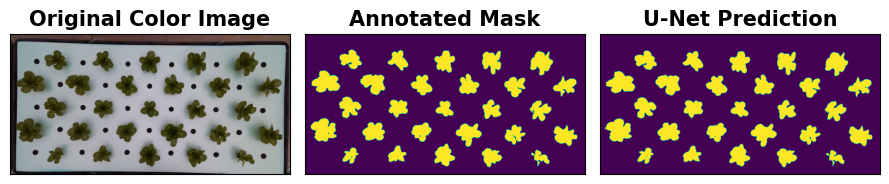

In [45]:
images = [img_rgb, original_mask, predicted_mask]
titles = ['Original Color Image', 'Annotated Mask', 'U-Net Prediction']

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Iterate through subplots and data
for ax, image, title in zip(axs.flatten(), images, titles):
    ax.imshow(image)
    if title:
        ax.set_title(title, fontsize=15, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig('../output/01-05_UNet.png', dpi=350) 